In [81]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output
    

In [82]:
dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))

# censor the 'answers'
features2drop = [(f,a) for f,a in divisions.columns if 'Time' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'smoothed' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'standard' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'cell coords' in f and not 'rate' in f]
features2drop += [(f,a) for f,a in divisions.columns if 'Manual' in f]
features2drop += ['Z','Z-cyto']
divisions = divisions.drop(columns=features2drop)
print(len(divisions))

model_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Random_forest_division'
importances = pd.read_csv(path.join(model_dir,'importances.csv'),index_col=0)
importances = importances.rename(columns={'0':'RF imp'})

%loadext autoreload
%autoreload 2

668


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_27022/3210377611.py:12: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  divisions = divisions.drop(columns=features2drop)
UsageError: Line magic function `%loadext` not found.


/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


(Text(0.5, 0, '# Components'), Text(0, 0.5, '% variance explained'))

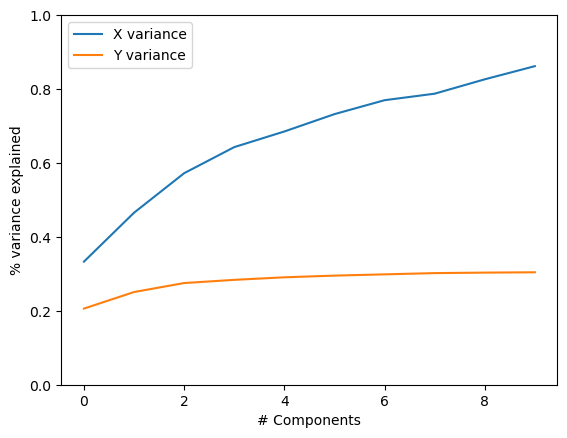

In [83]:
from sklearn import cross_decomposition

# Full data description mode
_df = divisions[~np.isnan(divisions['At least one daughter differentiated','Meta'].astype(float))]

X = _df.droplevel(axis=1,level=1)[importances.tail(20).index].dropna(axis=1)
Y = _df['At least one daughter differentiated','Meta'].values.reshape(-1, 1)

n_components = 10

pls = cross_decomposition.PLSRegression(n_components=n_components,scale=True)
pls.fit(X,Y)

X_scaled = preprocessing.StandardScaler().fit_transform(X)
X_transformed = pls.transform(X_scaled)

Y_scaled = preprocessing.StandardScaler().fit_transform(Y)

var_explained_X = np.zeros(n_components)
var_explained_Y = np.zeros(n_components)

for i in range(n_components):
    # Reconstruct X using first i+1 components
    scores = pls.transform(X)[:, :i+1]
    # Reconstruct X: scores @ loadings.T
    X_reconstructed = scores @ pls.x_loadings_[:, :i+1].T
    var_explained_X[i] = 1 - np.sum((X_scaled - X_reconstructed)**2) / np.sum(X_scaled**2)

    # Refit with i+1 components
    pls_temp = cross_decomposition.PLSRegression(n_components=i+1, scale=True)
    pls_temp.fit(X, Y)
    y_pred = pls_temp.predict(X)
    
    # Calculate R² for Y
    var_explained_Y[i] = 1 - np.sum((Y - y_pred)**2) / np.sum((Y - Y.mean(axis=0))**2)

plt.plot(var_explained_X);plt.ylim([0,1])
plt.plot(var_explained_Y);plt.ylim([0,1])
plt.legend(['X variance','Y variance']);plt.xlabel('# Components'),plt.ylabel('% variance explained')

In [79]:
n_comp = 20

pls = cross_decomposition.PLSRegression(n_components=n_components,scale=True)
pls.fit(X,Y)

,n_components,10
,scale,True
,max_iter,500
,tol,1e-06
,copy,True


In [80]:
coefs = pd.DataFrame(pls.coef_,columns=X.columns,index=['Daughter fate']).T
coefs.sort_values('Daughter fate')
# coefs.loc['Relative Height to BM']


,Daughter fate
Name,
Relative nuc_shcoeffs_L0M0C,-1.592506
Relative nuc_shcoeffs_surface_area,-0.493151
Median adjac cyto_shcoeffs_L5M5S,-0.461335
nuc_shcoeffs_L3M2S,-0.450818
Relative Total H2B intensity,-0.352722
Mean adjac Mean curvature,-0.198940
Relative cyto_shcoeffs_surface_area,-0.044122
cyto_shcoeffs_L1M0C,-0.014644
Axial component,-0.003210


In [70]:
coefs.loc['Mean curvature']

Daughter fate   -0.051286
Name: Mean curvature, dtype: float64